# RNN, LSTM, and GRU

## Introduction
This notebook contains some of the details for the implementation of Recurrent Neural Networks (RNNs) and two variants of it, the LSTM and GRU. To see the full implementation, see the source code [here](https://github.com/hongjos/rnn). Recurrent Neural Networks (RNNs) were introduced in the 1980s, with the aim of modeling sequences of data, such as text, music, and time series. However, early RNN models faced challenges with learning long-term dependencies, which limited their effectiveness. To deal with this, variants of the RNN were introduced later such as the LSTM and GRU.

To test and compare implementations of the RNN, LSTM and GRU, we will use the [IMDB Movie Reviews dataset](https://keras.io/api/datasets/imdb/) for sentiment classification.

This notebook just gives a standard implementation of the models to get a better understanding of them. You shouldn't actually use this implementation to do real life stuff. Instead, you should be using the ones from frameworks such as [PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) or [TensorFlow](https://www.tensorflow.org/guide/keras/rnn).


## Prelims
The implementation for the RNN will primarily use `numpy`. Other libraries used in this notebook are just for getting the data and visualizing the results. 

In [45]:
from rnn import RNN
from lstm import LSTM
from gru import GRU
from activation import *
from utils import *

import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import imdb

### One-Hot Encoding
To represent words as numerical values, we can represent each word as a vector with a 1 in the index that identifies the word and 0s elsewhere. For example, if you were a baby and only knew the words "goo" and "ga". We can use 0 to represent the "goo" and 1 for "ga". Then the phrase "goo goo ga ga" would look something like:

In [14]:
vocab = {'goo' : 0, 'ga' : 1}
phrase = ['goo', 'goo', 'ga', 'ga']

[vocab[x] for x in phrase]

[0, 0, 1, 1]

The one-hot encoding would look something like:

In [13]:
seq = np.zeros((len(phrase), 2))

for i, word in enumerate(phrase):
    seq[i][vocab[word]] = 1

seq

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

## RNN
RNNs are a class of neural networks that allow previous outputs to be used as inputs. Unlike traditional feedforward neural networks that operate on a fixed-sized input, RNNs have a feedback loop that allows them to operate on inputs of variable length. This loop enables RNNs to allow information to persist or retain a memory of the previous inputs, making it particularly useful for tasks such as language modeling, machine translation, and speech recognition.

<div>
<img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/architecture-rnn-ltr.png?9ea4417fc145b9346a3e288801dbdfdc" width="800"/>
</div>

All images from taken from [here](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks).

RNNs have hidden states, which refer to the memory of the network,  that serves as a summary of the information seen by the network up to that point in time.

There are different types of RNN models used for different types of natural language processing tasks. For example, if we wanted to do something like named-entity recognition, we would use a "many-to-many" model, where we would need to compute the output at each time step.

<div>
<img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/rnn-many-to-many-same-ltr.png?2790431b32050b34b80011afead1f232" width="600"/>
</div>

For this notebook, we are focused on sentiment classification, so we only care about the output at the last time step. The type of model used for this is called a "many-to-one" model. 

<div>
<img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/rnn-many-to-one-ltr.png?c8a442b3ea9f4cb81f929c089b910c9d" width="600"/>
</div>

### The Base Class
The four main methods that will be used when implementing neural networks like the RNN are:
- `forward` function: forward propagate through the model
- `backward` function: back propagate through the model
- `loss` function: computes the loss of the model
- `optimize` function: updating the parameters

In [ ]:
class BaseModel:
    def __init__(self, input_dim, output_dim, hidden_dim):
        """
        Initialize model.
        """

    def forward(self, X):
        """
        This is where forward propagation should happen.
        """
    
    def backward(self, X, Y, Y_hat):
        """
        This is where back propagation should happen.
        """
    
    def loss(self, Y, Y_hat):
        """
        Compute the loss of the model.
        """
    
    def optimize(self):
        """
        This is where the parameters are updated.
        """

### Activation Functions
Activation functions are functions used in neural networks that introduce non-linearity into the output of a neural network node. These functions functions are applied to the weighted sum of inputs and biases to calculate the output of a node. The output of the activation function is used to determine whether the node should be activated or not.

Common activation functions used in RNNS are: 

| Sigmoid | Tanh | ReLU |
| --- | --- | --- |
| $g(z) = \frac{1}{1 + e^{-z}}$ | $g(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$ | $g(z) = \max(0,z)$ |
|<div><img src="https://stanford.edu/~shervine/teaching/cs-229/illustrations/sigmoid.png?c91b6e5a7d4e78e95880bcf4e39889df" width="200"/></div>|<img src="https://stanford.edu/~shervine/teaching/cs-229/illustrations/tanh.png?22ac27f27c510c6414e8a3bb4aca2d80" width="200"/></div> |<img src="https://stanford.edu/~shervine/teaching/cs-229/illustrations/relu.png?6c1d78551355db5c6e4f6f8b5282cfa8" width="200"/></div>|

In this implementation, we will be using the sigmoid and tanh activation functions. Since this notebook focuses on using the RNN for sentiment classifcation, we also use the softmax activation function to get a probability distribution for each of the classes given as:
$$\sigma(z)_i = \frac{e^{z_i}}{\sum_{i=1}^{K} e^{z_j}}$$
where $K$ is the number of classes we have.

In [20]:
softmax = Softmax() # softmax activation function
sigmoid = Sigmoid() # sigmoid activation function 
tanh = Tanh()       # tanh activation function

### Initialization
The `input_dim` for the RNN will be the size of our vocabulary, the `hidden_dim` refers to the number of hidden units we want, and the `output_dim` will be the number of classes.

The RNN has coefficients: 
- $W_{ax}$: weight matrix corresponding to the input to hidden state
- $W_{aa}$: weight matrix for previous hidden to  current hidden state (recurrent computation)
- $W_{ya}$: weight matrix corresponding to the hidden state to the output
- $b_{a}$: bias for hidden
- $b_{y}$: bias for output

We also keep track of the gradients for each parameter which will be used during the `backward` step.

Instead of making everything zero, we randomly initialize the weights. By doing so, we make sure the each hidden unit computes a different function and receives a different update during backpropagation, which improves the model's ability to learn.

In [5]:
P = {} # parameters
G = {} # gradients

def init(self, input_dim, output_dim, hidden_dim, learning_rate=.1, type='many-to-one'):
    dlen = np.sqrt(hidden_dim) # used to normalize weights
    
    # initialize parameters
    P['W_ax'] = np.random.randn(hidden_dim, input_dim) / dlen    # weight matrix (input to hidden state)
    P['W_aa'] = np.random.randn(hidden_dim, hidden_dim) / dlen   # weight matrix (recurrent, hidden to hidden)
    P['W_ya'] = np.random.randn(output_dim, hidden_dim) / dlen   # weight matrix (hidden to output)
    
    P['b_a'] = np.zeros((hidden_dim, 1))                         # bias (hidden)
    P['b_y'] = np.zeros((output_dim, 1))                         # bias (output)

    # initialize hidden state
    hidden = np.zeros((self.hidden_dim, 1))        

### Forward Pass
During the forward pass of the RNN, the actvation $a^{<t>}$ and output $y^{<t>}$ are computed as:

$$a^{<t>} = g_1(W_{aa}a^{<t-1>} + W_{ax}x^{<t>} + b_a),~ y^{<t>} = g_2(W_{ya}a^{<t>} + b_y)$$

for each time step, where $g_1$ and $g_2$ are activation functions.
<div>
<img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/description-block-rnn-ltr.png?74e25518f882f8758439bcb3637715e5" width="700"/>
</div>

In a "many-to-many" RNN, we return the output at each time step, but for sentiment classification ("many-to-one"), we just return the last output.

In [4]:
# keep track of hidden states and outputs
hidden_states = []
outputs = [] 

def forward(self, X):
    # iterate through each element in the input vector
    for t in range(len(X)):
        # compute new hidden state
        hidden = tanh(np.dot(P['W_aa'], hidden) + np.dot(P['W_ax'], X[t]) + P['b_a'])

        # compute output
        y = softmax(np.dot(P['W_ya'], hidden) + P['b_y'])

        # store output and hidden state
        hidden_states.append(hidden.copy())
        outputs.append(y)

### Loss Function
Before we backpropagate through the RNN, we must first compute the loss of the predicted output and the actual output. For classification, we will use the cross-entropy loss function defined as:
$$\mathcal{L}(y,\hat{y}) = -\sum_{i=1}^{n}y_i\log(\hat{y}_i)$$
and the gradient is calculated as:
$$\frac{\partial \mathcal{L}}{\partial o_i} = \hat{y}_i - y_i$$


### Backpropagation
In order to minimize the loss of the model, we compute the gradient of the loss function with respect to the weights of the network. These gradients are calculated through the chain rule method.


In [ ]:
loss_function = CELoss()

def backward(self, X, Y, Y_hat):
        da_next = np.zeros_like(hidden_states[0]) # keeps track of derivative for next hidden state

        # compute the loss
        loss = loss_function(Y, Y_hat)
        # compute the gradient of the loss w.r.t output
        dy = loss_function.derivative()
        
        # go through hidden layers and update gradients
        for t in reversed(range(len(hidden_states))):
            # update gradients for output weights and bias
            G['dW_ya'] += np.dot(dy, hidden_states[t].T)
            G['db_y'] += dy

            # compute gradient for hidden state
            da = np.dot(P['W_ya'].T, dy) + da_next 

            # update gradients for hidden weights and bias
            dtanh = tanh.derivative(hidden_states[t])*da
            G['db_a'] += dtanh
            G['dW_ax'] += np.dot(dtanh, X[t].T)
            G['dW_aa'] += np.dot(dtanh, hidden_states[t-1].T)

            # update gradient for next hidden state
            da_next = np.dot(P['W_aa'].T, dtanh)

        # clip gradients
        clip_gradients(G)

#### Gradient Clipping
Because RNNs can get quite long, during backpropagation, the gradient values can become too large, causing the weights to update too much. This can lead to numerical instability and failure to converge. Clipping the gradients sets a maximum threshold for the gradient values, allowing for stable updates to the weights.

<div>
<img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/gradient-clipping-en.png?6c3de441dc56aad634dc1a91accb48f2" width="500"/>
</div>

### Optimization
After calculating the gradients the parameters of the model need to be adjusted inorder to minimize the loss. The end goal is to find the set of parameters that result in the best performance. In this implementation, we will use the Stochastic Gradient Descent (SGD) optimizer, with the update rule given by:

$$\theta_i := \theta_i - \eta \frac{\partial\mathcal{L}}{\partial \theta_i}$$

where $\eta$ is the learning rate.

## LSTM
Sometimes information from earlier time steps need to be carried forward in order to make accurate predictions at later time steps. This is called “long-term dependencies'', and while RNNs are capable of handling them, in practice they tend to struggle with “long-term dependencies.” Like exploding gradients, RNNs also suffer from the vanishing gradient problem where the values of the gradients become too small to work with.

In order to deal with this, specific gates are used in variants of the RNN, denoted as
$$\Gamma = \sigma(Wx^{<t>} + Ua^{<t-1>} + b)$$

where $W,U,b$ are coefficients specific to the gate and $\sigma$ is the sigmoid function.

LSTM (long short-term memory) networks are a variant of RNNs, which has an additional memory cell state that stores information over time  or long-term memory. The hidden state of the LSTM refers to the short-term memory

The LSTM consists of four gates:
- Forget gate: controls whether to "forget"/erase data from the cell
- Input gate: controls the amount of new information that enters the cell
- Candidate gate: controls what data to write to the cell
- Output gate: controls what data to pass as the output hidden state

<div>
<img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/lstm-ltr.png?4539fbbcbd9fabfd365936131c13476c" width="500"/>
</div>

### Forward Pass
The states of the LSTM are calculated as:
- $f_t=\sigma\left(W_f x_{t}+U_f h_{t-1}+b_f\right)$ (forget gate)
- $i_t=\sigma\left(W_i x_t+U_i h_{t-1}+b_i\right)$ (input gate)
- $o_t=\sigma\left(W_o x_{t}+U_o h_{t-1}+b_o\right)$ (output gate)
- $\widetilde{c}_t=\tanh \left(W_c x_{t}+U_c h_{t-1}+b_c\right)$ (cell candidate)
- $c_t=f_t \circ c_{t-1}+i_t \circ \widetilde{c}_t$ (cell state)
- $h_t=o_t \circ \tanh \left(c_t\right)$ (hidden state)

look at the code

### Backpropagation
look at the code.

## GRU
A more simple alternative to LSTM networks is the GRU (gated recurrent unit) network. The GRU does not have an output gate, and combines the input and forget gate into a single update gate. This update gate determines the amount of previous information that will be passed on. It also introduces a new gate called the reset gate, which decides how much of the past information is neglected.

<div>
<img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/gru-ltr.png?00f278f71b4833d32a87ed53d86f251c" width="500"/>
</div> 

### Forward Pass
The states of the GRU are calculated as:
- $u_t =\sigma_g\left(W_u x_t+U_u h_{t-1}+b_u\right)$ (update gate)
- $r_t =\sigma_g\left(W_r x_t+U_r h_{t-1}+b_r\right)$ (reset gate)
- $\widetilde{h}_t =\phi_h\left(W_h x_t+U_h\left(r_t \odot h_{t-1}\right)+b_h\right)$ (candidate)
- $h_t =\left(1-z_t\right) \odot h_{t-1}+z_t \odot \widetilde{h}_t$ (hidden)

## Evaluation on IMDB Dataset
To test and compare the models we will use the IMDB Movie Reviews Dataset. The dataset consists of 25,000 movie reviews from IMDB, labeled by sentiment (positive/negative), and the words are indexed by overall frequency in the dataset e.g. `3` encodes the third most frequent word.

In [46]:
(X_train, y_train), (X_test, y_test) = imdb.load_data() # get the data

word_index = imdb.get_word_index()
index_to_word = dict([(value,key) for (key,value) in word_index.items()])

an example:

In [47]:
def decode(input):
    sentence = []
    for i in input:
        sentence.append(index_to_word.get(i-3, ''))
    print(" ".join(sentence))
    return sentence

decode(X_train[0]);

 this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be 

### Preprocessing
Because RNNs can be very slow, especially when dealing with longer sequences, we will only use a small portion of the vocabulary and very small portion of the dataset. Do note that there are ways to speed up computation like parallel processing.

To make sure we sure the model does not get biased towards one class, we get a fair split of positive and negative examples.

In [94]:
num_examples = 100 # number of examples used
half = int(num_examples/2)

indx = np.zeros(num_examples, dtype=np.int8) # indices to look at
test = np.array([1,2,3])

pos_count, neg_count = 0, 0

for i, y in enumerate(y_train):
    if y == 0 and pos_count < half:
        # positive found, increment positive
        indx[pos_count] = int(i) 
        pos_count += 1
    elif y == 1 and neg_count < half:
        # negative found, increment negative
        indx[neg_count+half] = int(i)
        neg_count += 1
    elif pos_count >= half and neg_count >= half:
        break
    else:
        continue


X_small, y_small = X_train[indx], y_train[indx]

The most frequent appearing words are pretty useless and will probably not help the model so we will ignore them.

In [176]:
for i in range(10):
    print(index_to_word[i+1])

the
and
a
of
to
is
br
in
it
i


In [95]:
vocab_size = 50
def remove_unwanted(lst, min=10, max=vocab_size):
    """
    Remove unwanted words.
    """
    new = []
    for x in lst:
        # word index cutoff
        if x - 3 > min and x < max+min:
            new.append(x-min)
    return new

X_small = [remove_unwanted(x) for x in X_small]

Converting the words to vectors.

In [96]:
def one_hot_x(X, size=vocab_size):
    """
    One-hot encoding for the input data.
    """
    ret = [None] * len(X)
    # go through each movie review
    for i, seq in enumerate(X):
        xx = np.zeros((len(seq), size, 1))
        # go through each sequence
        for j, val in enumerate(seq):
            xx[j][val] = 1 # set word index to 1
        ret[i] = xx # add to list
    
    return ret

def one_hot_y(Y, num_class=2):
    """
    One-hot encoding for the output data.
    """
    ret = [None] * Y.size
    # go through each classification
    for i, val in enumerate(Y):
        y = np.zeros((num_class, 1))
        y[val] = 1 # set value to 1
        ret[i] = y # add to list
    
    return ret

x_input = one_hot_x(X_small)
y_input = one_hot_y(y_small)
x_input[0].shape

(32, 50, 1)

### Training

In [ ]:
np.random.seed(42) # set random seed for replication

Training the RNN Model.

In [145]:
num_epochs = 17
RNN_Model = RNN(input_dim=vocab_size, hidden_dim=15, output_dim=2, learning_rate=1e-4)
RNN_loss = RNN_Model.fit(x_input, y_input, num_epochs)

Epoch 0, training loss: 36.096146821318705
Epoch 5, training loss: 35.944958743287344
Epoch 10, training loss: 35.865672646366825
Epoch 15, training loss: 35.824320577752104


Training the LSTM Model.

In [170]:
LSTM_Model = LSTM(input_dim=vocab_size, hidden_dim=15, output_dim=2, learning_rate=2.8e-3)
LSTM_loss = LSTM_Model.fit(x_input, y_input, num_epochs)

Epoch 0, training loss: 35.03202848942975
Epoch 5, training loss: 34.88303149085208
Epoch 10, training loss: 34.86923786003565
Epoch 15, training loss: 34.71723461717235


Training the GRU Model.

In [161]:
GRU_Model = GRU(input_dim=vocab_size, hidden_dim=15, output_dim=2, learning_rate=3e-4)
GRU_loss = GRU_Model.fit(x_input, y_input, num_epochs)

Epoch 0, training loss: 35.99295761260045
Epoch 5, training loss: 35.505573024038995
Epoch 10, training loss: 35.45425231403333
Epoch 15, training loss: 35.460536879621


### Evaluation
Comparing Model Loss.

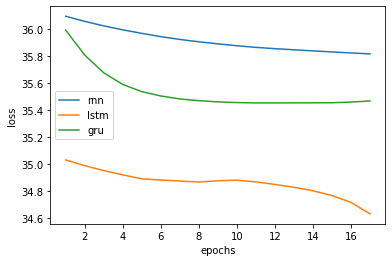

In [171]:
x = range(1, num_epochs+1)
plt.plot(x, RNN_loss, label ='rnn')
plt.plot(x, LSTM_loss, label ='lstm')
plt.plot(x, GRU_loss, label ='gru')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

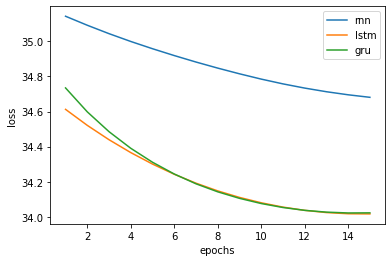

In [214]:
x = range(1,16)
plt.plot(x, RNN_loss, label ='rnn')
plt.plot(x, LSTM_loss, label ='lstm')
plt.plot(x, GRU_loss, label ='gru')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

Comparing the time taken.

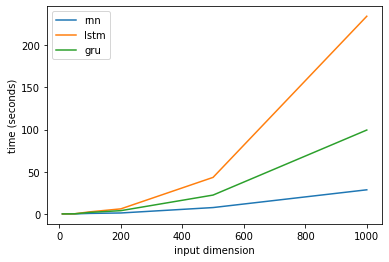

In [28]:
sizes = [10, 20, 50, 100, 200, 500, 1000]
model_times= [[], [], []]

(X_tiny, y_tiny) = (X_train[0:10], y_train[0:10])
y_test = one_hot_y(y_tiny)

for s in sizes:
    X_test = [remove_unwanted(x, min=1, max=s) for x in X_tiny.copy()]
    X_test = one_hot_x(X_test, size=s)

    RNN_test = RNN(input_dim=s, hidden_dim=s, output_dim=2)
    LSTM_test = LSTM(input_dim=s, hidden_dim=s, output_dim=2)
    GRU_test = GRU(input_dim=s, hidden_dim=s, output_dim=2)

    models = [RNN_test, LSTM_test, GRU_test]

    for i, model in enumerate(models):
        start = time.time()
        model.fit(X_test, y_test, num_epochs=1, print_flag=False)
        end = time.time() # calculate time taken
        model_times[i].append(end - start) # add to list

plt.plot(sizes, model_times[0], label ='rnn')
plt.plot(sizes, model_times[1], label ='lstm')
plt.plot(sizes, model_times[2], label ='gru')

plt.xlabel("input dimension")
plt.ylabel("time (seconds)")
plt.legend()
plt.show()